# Cervical Cancer Screening.
https://www.kaggle.com/c/intel-mobileodt-cervical-cancer-screening 

> In this competition, you'll work with an image dataset to accurately determine cervix types. Doing so is critical to providing cervical cancer treatments that work for all women regardless of their physiology.

In this notebook, I'll extract features from the images using a pretrained deep model (ResNet50), and then experiment with different techniques for trying to improve the predictive performance of an XGBoost model. Starting with a model with default parameters, I do hyperparameter optimization  and probability calibration to try to decrease the log loss of the model

In [1]:
from __future__ import print_function

In [2]:
from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### The Data

In [3]:
data_path = "/home/ubuntu/data/"

In [4]:
#1. List of training images

import os, shutil
import pandas as pd
dataset_path = data_path + "train/"
train_images = pd.DataFrame(columns=["Class", "Image", "Imagepath"])
for (folder, subs, files) in os.walk(dataset_path):
    for filename in files:
        label = folder.split("/")[-1]
        imagepath = os.path.join(folder, filename)
        if filename.endswith(".jpg"):
            train_images = train_images.append({"Class":label, 
                                                "Image":filename, 
                                                "Imagepath":imagepath}, 
                                               ignore_index=True)

In [8]:
train_images.head()

,Class,Image,Imagepath
0,Type_3,944.jpg,/home/ubuntu/data/train/Type_3/944.jpg
1,Type_3,427.jpg,/home/ubuntu/data/train/Type_3/427.jpg
2,Type_3,258.jpg,/home/ubuntu/data/train/Type_3/258.jpg
3,Type_3,1372.jpg,/home/ubuntu/data/train/Type_3/1372.jpg
4,Type_3,494.jpg,/home/ubuntu/data/train/Type_3/494.jpg


In [10]:
train_images = train_images[train_images["Image"] != ".DS_Store"]

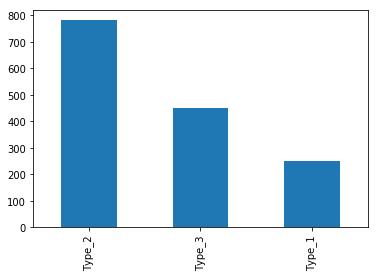

In [14]:
#Class distribution

%matplotlib inline
train_images["Class"].value_counts().plot(kind='bar')

In [ ]:
#2. Optional: Move all the images into the train directory

for origin in train_images["Imagepath"]:
    l = origin.split("/")
    l.pop(-2)
    dest = "/".join(l)
    shutil.move(origin, dest)

In [15]:
#3. Save train image list

train_images.to_csv(data_path+"train_set.csv", index=False)

In [16]:
#4. List of test images

dataset_path = data_path + "test/"
test_images = pd.DataFrame(columns=["Image", "Imagepath"])
for (folder, subs, files) in os.walk(dataset_path):
    for filename in files:
        imagepath = os.path.join(folder, filename)
        if filename.endswith(".jpg"):
            test_images = test_images.append({"Image":filename, 
                                                "Imagepath":imagepath}, 
                                               ignore_index=True)


In [17]:
test_images.head()

,Image,Imagepath
0,427.jpg,/home/ubuntu/data/test/427.jpg
1,258.jpg,/home/ubuntu/data/test/258.jpg
2,376.jpg,/home/ubuntu/data/test/376.jpg
3,131.jpg,/home/ubuntu/data/test/131.jpg
4,494.jpg,/home/ubuntu/data/test/494.jpg


In [18]:
test_images = test_images[test_images["Image"] != ".DS_Store"]

In [19]:
#5. Save test image list

test_images.to_csv(data_path+"test_set.csv", index=False)

### Feature Extraction

Extracting features with a pretrained deep model

In [20]:
#Function to load an image as a numpy matrix

import numpy as np
from keras.preprocessing.image import img_to_array, load_img
def get_image_as_X(path_to_image_file, target_size, dim_ordering='th'):
    img = load_img(path_to_image_file, grayscale=False, target_size=target_size)
    x = img_to_array(img, dim_ordering=dim_ordering)
    x = np.expand_dims(x, axis=0)
    return x

In [32]:
#Function to extract features from an image with a pretrained model

def extract_features(image_list, image_size, model, preprocessing_function):
    features = []
    processed = []
    for image in image_list:
        try:
            x = get_image_as_X(image, image_size)
            x = preprocessing_function(x)
            p = model.predict(x)
            features.extend(p)
            processed.append(image)
        except Exception as e:
            print("Fail with image:", image)
            print(e)
            continue
    
    return features, processed

In [22]:
#Loading the model: ResNet50

img_size=(224, 224)
from keras.applications import resnet50
model = resnet50.ResNet50(weights='imagenet', include_top=False)

In [24]:
#Image lists
train_image_list = train_images["Imagepath"].as_matrix()
test_image_list = test_images["Imagepath"].as_matrix()

In [26]:
print(len(train_image_list))
print(len(test_image_list))

1481
512


In [33]:
%%time

#Extracting features of the training images

features_resnet50, train_processed = extract_features(train_image_list, img_size, model, resnet50.preprocess_input)
features_resnet50_train = np.array(features_resnet50)
print(features_resnet50_train.shape)

Fail with image: /home/ubuntu/data/train/Type_1/1339.jpg
image file is truncated (54 bytes not processed)
(1480, 2048, 1, 1)
CPU times: user 6min 50s, sys: 1min 8s, total: 7min 59s
Wall time: 8min 1s


In [50]:
fails = [f for f in train_image_list if f not in train_processed]
if fails:
    train_images = train_images[~train_images["Imagepath"].isin(fails)]
    train_images.to_csv(data_path+"train_set.csv", index=False)

In [38]:
%%time

#Extracting features of the test images

features_resnet50, test_processed = extract_features(test_image_list, img_size, model, resnet50.preprocess_input)
features_resnet50_test = np.array(features_resnet50)
print(features_resnet50_test.shape)

(512, 2048, 1, 1)
CPU times: user 2min 24s, sys: 18.2 s, total: 2min 42s
Wall time: 2min 43s


In [48]:
fails = [f for f in test_image_list if f not in test_processed]
if fails:
    test_images = test_images[~test_images["Imagepath"].isin(fails)]


In [49]:
#Saving Features
np.save(data_path+"features_resnet50_train.npy", features_resnet50_train)
np.save(data_path+"features_resnet50_test.npy", features_resnet50_test)

In [52]:
X_train = np.reshape(features_resnet50_train, (1480, 2048))
X_test = np.reshape(features_resnet50_test, (512, 2048))
print(X_train.shape)
print(X_test.shape)

(1480, 2048)
(512, 2048)


In [55]:
y_train = train_images["Class"].as_matrix()
len(y_train)

1480

### Building the model

Default model

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [58]:
model = XGBClassifier()

In [61]:
%%time
model = model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)

CPU times: user 1min 49s, sys: 28 ms, total: 1min 49s
Wall time: 13.8 s


In [62]:
model.classes_

array(['Type_1', 'Type_2', 'Type_3'], dtype=object)

In [66]:
import datetime
def create_submission(path, predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['Type_1', 'Type_2', 'Type_3'])
    result1.loc[:, 'image_name'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    print("Writing " + sub_file)
    result1.to_csv(path+sub_file, index=False)

In [67]:
create_submission(data_path, predictions, test_images["Image"], "XGB_with_resnet50_feats")

Writing submission_XGB_with_resnet50_feats_2017-03-15-23-38.csv


*Public Score: 0.88670*

Model with hyperparameter optimization

In [72]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold, train_test_split

In [74]:
def cross_validated_scorer(X_train, y_train, model_class, params, loss, kfolds=3):
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    print("Training with params : %s" % (params))
    mod = model_class(**params)
    cv_score = -1 * cross_val_score(mod, X_train, y=y_train, scoring=loss, cv=kfolds, n_jobs=1).mean()
    print(cv_score)
    return cv_score

def optimize(trials):
    hyperopt_grid = {
            'max_depth' : hp.quniform('max_depth', 1, 10, 1),
            'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
            'n_estimators' : hp.quniform('n_estimators', 25, 525, 25),
            'gamma' : hp.quniform('gamma', 0.0, 1.0, 0.05),
            'min_child_weight' : hp.quniform('min_child_weight', 1, 4, 1),
            'subsample' : hp.quniform('subsample', 0.2, 1, 0.1),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.2, 1.0, 0.1)
    }
    
    def objective(params):
        err = cross_validated_scorer(X_train, y_train, XGBClassifier, params, loss="neg_log_loss")
        return {'loss': err, 'params': params, 'status': STATUS_OK}
    best = fmin(objective, hyperopt_grid, algo=tpe.suggest, trials=trials, max_evals=25)
    return best

In [75]:
%%time
trials = Trials()
best = optimize(trials)

Training with params : {'n_estimators': 400, 'subsample': 0.5, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.21, 'max_depth': 10, 'min_child_weight': 1.0}
0.966873901842
Training with params : {'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'gamma': 0.0, 'learning_rate': 0.32, 'max_depth': 5, 'min_child_weight': 3.0}
1.0971647344
Training with params : {'n_estimators': 325, 'subsample': 0.2, 'colsample_bytree': 0.9, 'gamma': 0.4, 'learning_rate': 0.08, 'max_depth': 5, 'min_child_weight': 3.0}
1.00481793258
Training with params : {'n_estimators': 475, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.30000000000000004, 'gamma': 0.25, 'learning_rate': 0.08, 'max_depth': 3, 'min_child_weight': 3.0}
0.998628793638
Training with params : {'n_estimators': 400, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.45, 'learning_rate': 0.36, 'max_depth': 4, 'min_child_weight': 3.0}
1.03067603484
Trai

In [76]:
best["n_estimators"] = int(best["n_estimators"])
best["max_depth"] = int(best["max_depth"])
print(best)

{'colsample_bytree': 0.5, 'learning_rate': 0.04, 'min_child_weight': 4.0, 'n_estimators': 150, 'subsample': 0.7000000000000001, 'max_depth': 2, 'gamma': 0.6000000000000001}


In [77]:
%%time
model = XGBClassifier(**best)
model = model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)

CPU times: user 53.7 s, sys: 8 ms, total: 53.7 s
Wall time: 6.77 s


In [78]:
create_submission(data_path, predictions, test_images["Image"], "XGB_with_resnet50_feats_opt")

Writing submission_XGB_with_resnet50_feats_opt_2017-03-16-00-16.csv


*Public Score: 0.86861*

Model probability calibration

In [83]:
from sklearn.calibration import CalibratedClassifierCV
best_model = CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=10)

In [84]:
%%time
best_model = best_model.fit(X_train, y_train)
predictions = best_model.predict_proba(X_test)

CPU times: user 8min 2s, sys: 184 ms, total: 8min 2s
Wall time: 1min 1s


In [85]:
create_submission(data_path, predictions, test_images["Image"], "XGB_with_resnet50_feats-opt-calibrated")

Writing submission_XGB_with_resnet50_feats-opt-calibrated_2017-03-16-00-23.csv


*Public Score: 0.86595*